# MNIST

### MNIST 데이터 받기

In [1]:
import os
import sys
from six.moves import urllib
import gzip
import pickle
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


SOURCE_URL = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
FILENAME = SOURCE_URL.split('/')[-1]
DATA_DIR = './datasets'

def maybe_download(data_dir):
    filepath = os.path.join(data_dir, FILENAME)
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    if not os.path.isfile(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading {} {:.1f} %'.format(
                FILENAME, float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL, filepath, _progress)
        print()
        statinfo = os.stat(filepath)
        print('Successfully donloaded', FILENAME, statinfo.st_size, 'bytes.')

def load(data_dir, subset='train'):
    maybe_download(data_dir)
    filepath = os.path.join(data_dir, FILENAME)
    
    f = gzip.open(filepath, 'rb')
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    train_set, valid_set, test_set = u.load()
    f.close()
    
    if subset == 'train':
        trainx, trainy = train_set
        trainx = trainx.astype(np.float32).reshape(trainx.shape[0], 28, 28)
        trainy = trainy.astype(np.uint8)
        return trainx, trainy
    elif subset == 'test':
        testx, testy = test_set
        testx = testx.astype(np.float32).reshape(testx.shape[0], 28, 28)
        testy = testy.astype(np.uint8)
        return testx, testy
    elif subset== 'valid':
        validx, validy = valid_set
        validx = validx.astype(np.float32).reshape(validx.shape[0], 28, 28)
        validy = validy.astype(np.uint8)
        return validx, validy
    else:
        raise NotImplementedError('subset should be train or valid or test')

# Load data
train_data, train_label = load(DATA_DIR, 'train')
valid_data, valid_label = load(DATA_DIR, 'valid')
test_data, test_label = load(DATA_DIR, 'test')

# concatenate train and valid data as train data
train_data = np.concatenate((train_data, valid_data))
train_label = np.concatenate((train_label, valid_label))

### MNIST 데이터 확인 하기

In [2]:
# size of MNIST
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


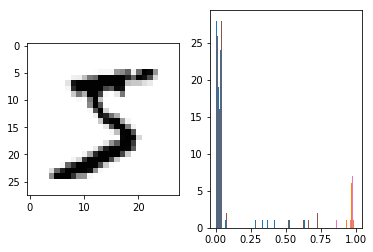

In [3]:
# show data
_, (ax1, ax2) = plt.subplots(1, 2)
sample_data = train_data[0]
ax1.imshow(sample_data, cmap=plt.cm.Greys);
ax2.hist(sample_data, bins=20, range=[0, 1]);

In [2]:
import tensorflow as tf
def model(X,by):
    X = tf.expand_dims(X, axis = 3)
    with tf.variable_scope('first'):
        outs = tf.layers.conv2d(X,128,3 , padding ='same') # filter : 128, kernel : 3
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling2d(outs,2,2) # stride : 2, size = 2
    with tf.variable_scope('second'):
        outs = tf.layers.conv2d(X,256,3, padding ='same') # filter : 256, kernel : 3
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling2d(outs,2,2) # stride : 2, size = 2
    with tf.variable_scope('third'):
        outs = tf.layers.conv2d(X,128,3, padding ='same') # filter : 128, kernel : 3
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling2d(outs,2,2) # stride : 2, size = 2
    print(outs)
    outs = tf.reshape(outs,(-1,outs.shape[1]*outs.shape[2]*outs.shape[3]))
    outs = tf.layers.dense(outs,256)
    outs = tf.nn.relu(outs)
    outs = tf.layers.dense(outs,10)
    
    one_hot = tf.one_hot(by, 10)
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = one_hot,logits = outs)
    
    # optimizer
    loss = tf.reduce_mean(loss)
    opt = tf.train.AdamOptimizer(1e-3).minimize(loss)
    
    #Accuracy 측정
    preds = tf.cast(tf.argmax(tf.nn.softmax(outs), axis = 1),tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(by,preds),tf.float32))
    return{
        'loss':loss,
        'opt':opt,
        'preds':preds,
        'acc':acc
        # tensor들을 return 하는 것.
    }

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

X = tf.placeholder(tf.float32, shape=(None, 28,28))
by = tf.placeholder(tf.int32)
ours = model(X,by)
init = tf.global_variables_initializer()

### Hyperparameter 선언

In [ ]:
num_epochs = 100
batch_size = 100 
num_display= 100
num_samples = 60000
# 원래 batch_size를 할 떄 2진수로 뽑는데 epoch돌리고, suffle하고 뽑고 그렇게한다.

In [ ]:
with tf.Session() as sess:
    sess.run(init)
    for ind_epoch in range(0,num_epochs):
        print('Current iterationn {}'.format(ind_epoch+1))
        for ind_ in range(0,int(num_samples/batch_size)):
            batch_X = \
                train_data[ind_*batch_size:(ind_+1)*batch_size]
            batch_by = train_label[ind_*batch_size:(ind_+1)*batch_size]
            
            _, cur_loss, cur_acc = sess.run([ours['opt'], ours['loss'], ours['acc']],
                                           feed_dict={X: batch_X, by:batch_by})
            if ind_ % num_display == 0:
                print('loss {0:.4f} acc{1:.4f}'.format(cur_loss, cur_acc))
                
_, cur_loss, cur_acc = sess.run([ours['opt'], ours['loss'], ours['acc']],
                               feed_dict={X: test_data, by:test_label})
print('loss {0:.4f} acc{1:.4f}'.format(cur_loss, cur_acc))
    

##### 